In [1]:
from densenetwork import model_builder
from data import *
from sklearn.model_selection import train_test_split

2024-03-17 15:58:11.099964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 15:58:11.100030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 15:58:11.100943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 15:58:11.111395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 15:58:11.854994: W tensorflow/compiler/tf2

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

def make_or_restore_model(shape):
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return tf.keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    model = model_builder(shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, weight_decay=0.03), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
    return model

def plot_stats(history, model_name):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.savefig(model_name+'_acc.png')
    plt.clf()

    plt.plot(epochs, loss, 'r', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss")
    plt.legend(loc=0)
    plt.savefig(model_name+'_loss.png')
    plt.clf()

In [ ]:
def run_training(epochs=300, batch_size=30):
    x, y = simple_MLP_train_data(Structure.LVM)
    x = np.array(x)
    y = np.array(y)
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)
    with strategy.scope():
        model = make_or_restore_model(x.shape[1:])
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch}",
            save_freq="epoch"
        )
    ]

    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, callbacks=callbacks, batch_size=batch_size, verbose=2)

    model.save("simpleMLP.keras")
    plot_stats(history, "simpleMLP")

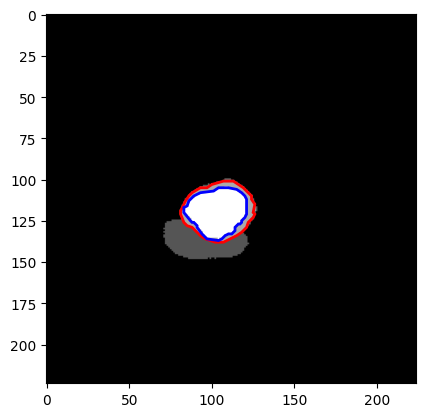

(224, 224, 10)


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 10


In [2]:
structure = Structure.LVM
i=12
dia_mask = img_mask_extraction(i, Frame.END_DIASTOLIC, CROP_SIZE)
sys_mask = img_mask_extraction(i, Frame.END_SYSTOLIC, CROP_SIZE)
dia_dict = get_features(dia_mask, structure)
sys_dict = get_features(sys_mask, structure)
static_dict = {}
print(dia_dict)
print(sys_dict)
for key, value in dia_dict.items():
    match key:
        case "mean_circularity":
            static_dict["mean_circularity"] = np.mean([value, sys_dict[key]])
        case "max_circumference":
            static_dict["max_circumference"] = np.max([value, sys_dict[key]])
        case "mean_circumference":
            static_dict["mean_circumference"] = np.mean([value, sys_dict[key]])
    if structure == Structure.LVM:
        match key:
            case "max_thickness":
                static_dict["max_thickness"] = np.max([value, sys_dict[key]])
            case "min_thickness":
                static_dict["min_thickness"] = np.min([value, sys_dict[key]])
            case "std_thickness":
                static_dict["std_thickness"] = math.sqrt((value**2 + sys_dict[key]**2) / 2)
            case "mean_thickness":
                static_dict["mean_thickness"] = np.mean([value, sys_dict[key]])
df = training_data_DF[['Group', 'Height', 'Weight']].loc[i-1]
static_dict['bmi'] = bmi(float(df['Height']), float(df['Weight']))
static_dict['body_surface_area'] = mosteller_method(float(df['Height']), float(df['Weight']))
features = np.array(list(static_dict.values()))
print(features)
print(features.shape)

In [ ]:
run_training(10,1)